In [1]:
%load_ext autoreload
%autoreload 2

from src.data.iris import IrisDataset
from src.models.toy import NetToyModel

from src.inference import MonteCarloInference
from src.samplers import Hamiltonian, MetropolisHastings

import torch
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = IrisDataset()

In [3]:
with torch.random.fork_rng():
    torch.manual_seed(123)
    train_data, test_data = torch.utils.data.random_split(dataset, [100, 50])

x_train, y_train = train_data[:]
x_test, y_test = test_data[:]

Use toy model, but with categorial likelihood

In [4]:
class IrisModel(NetToyModel):

    def log_likelihood(self, x: torch.FloatTensor, y: torch.LongTensor):
        """Returns log p(y | x, theta)"""
        logits = self.forward(x)
        observation_model = torch.distributions.Categorical(logits=logits)
        return observation_model.log_prob(y).sum()


In [5]:
model = IrisModel(4, 3)

In [6]:
sampler = Hamiltonian(step_size=0.04)
inference = MonteCarloInference(sampler=sampler)
inference.fit(model, train_data, burn_in=2000, n_samples=1000)

Sampling: 100%|██████████| 1000/1000 [00:08<00:00, 123.91it/s]


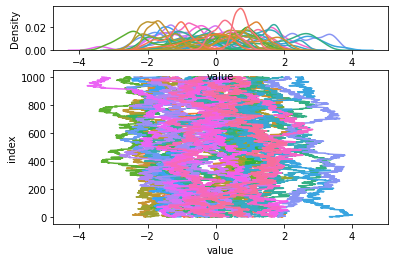

In [7]:
sample_df = pd.DataFrame({f"$c_{i}$" : c for i, c in enumerate(inference.samples_.T)})
plot_data = sample_df.reset_index().melt(id_vars="index")
fig = plt.figure()
grid_spec = fig.add_gridspec(2, 1, height_ratios=(2, 7))

ax_line = fig.add_subplot(grid_spec[1, 0])
ax_marg = fig.add_subplot(grid_spec[0, 0], sharex=ax_line)

sns.lineplot(x = "value", y="index", hue="variable", ax=ax_line, data=plot_data, sort=False, legend=False)
sns.kdeplot(x = "value", hue="variable", data=plot_data, legend=False)

plt.show()

In [8]:
y_pred_samples = inference.predictive(x_test)
y_pred = torch.tensor([v.bincount(minlength=3).argmax() for v in y_pred_samples.argmax(-1).T])

In [9]:
pca = PCA(2).fit(x_train)

In [10]:
certainty = (y_pred == y_pred_samples.argmax(-1)).sum(0) / 1000

<AxesSubplot:>

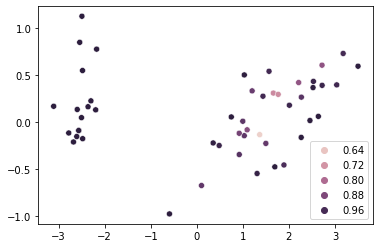

In [13]:
u, v = pca.transform(x_test).T
# sns.scatterplot(x=u, y=v, hue=y_pred)
sns.scatterplot(x=u, y=v, hue=certainty)
